
**Initiate and Configure Spark**

In [ ]:
# install the library
!pip install pyspark

In [ ]:
# mount the google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# import the requirede libraries
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import confusion_matrix
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.sql.types import DoubleType
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import IndexToString
from pyspark.sql.functions import sum, when, col
from pyspark.ml.classification import DecisionTreeClassifier,RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType

In [ ]:
spark = SparkSession.builder \
    .appName("Crimes In Chicago") \
    .getOrCreate()


**Load Data**


In [ ]:
# load the data from csv file
df = spark.read.option("header", "true").csv("/content/drive/MyDrive/project/*.csv")

In [ ]:
# display the data
df.show(5)

+---+-------+-----------+--------------------+-------------------+----+-------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|_c0|     ID|Case Number|                Date|              Block|IUCR| Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+---+-------+-----------+--------------------+-------------------+----+-------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|  0|4673626|   HM274058|04/02/2006 01:00:...|  055XX N MANGO AVE|2825|OTHER OFFENSE|HARASSMENT BY TEL...|           RESIDENCE| False|   Fa

In [ ]:
# check for the null values
df.agg(*[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns]).show()

+---+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|_c0| ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+---+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|  0|          7|   0|    0|   0|           0|          0|                1974|     0|       0|   0|      89|  92|          1844|       0|       74882|       74882|   0|         0|   74882|    74882|   74882|
+---+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------

In [ ]:
# drop the null values
df = df.dropna()

In [ ]:
# remove the outliers
df=df.filter((df["Latitude"] < 45) & (df["Latitude"] > 40) & (df["Longitude"] < -85) & (df["Longitude"] > -90))


This dataset contains information about criminal incidents that occurred in Chicago from 2001 to 2017, as reported by the Chicago Police Department.

The dataset contains a total of 7.1 million records, each representing a reported crime. Each record includes various attributes about the crime, such as the date and time of occurrence, the location (including latitude and longitude), the type of crime, the arrest status, and the domestic violence status.

Additionally, the dataset includes information on the primary and secondary descriptions of each crime, as well as the community area, ward, and police district where the crime occurred. It also includes information on the FBI's Uniform Crime Reporting (UCR) codes, which are used to categorize different types of crime.

**Clustering**

For k=2: 0.7205887508474291
For k=3: 0.5227611832191903
For k=4: 0.5225074497061222
For k=5: 0.5179599641362732
For k=6: 0.49287590729540487
For k=7: 0.5804057377676464
For k=8: 0.5764753866729306
For k=9: 0.5492814503375302
For k=10: 0.5448502714845224
For k=11: 0.5469813921351374
For k=12: 0.5620457918847751
For k=13: 0.5630618110126224
For k=14: 0.5561009133142536


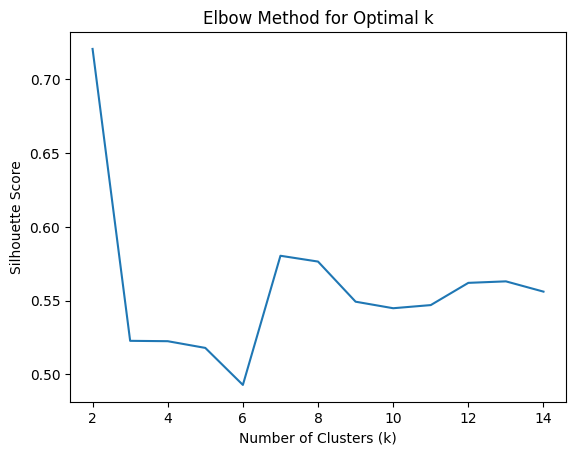

In [ ]:
# Select the columns that you want to use for clustering
columns = ['Latitude', 'Longitude']

# Convert the columns to numeric data types
df = df.withColumn('Latitude', df['Latitude'].cast('double'))
df = df.withColumn('Longitude', df['Longitude'].cast('double'))

# Create a vector assembler object
assembler = VectorAssembler(inputCols=columns, outputCol='features')

# Apply the vector assembler object to the dataframe
data = assembler.transform(df)

# Define a range of k values to test
k_values = range(2, 15)

# Train and evaluate the KMeans model for each k value
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(data.select('features'))
    predictions = model.transform(data.select('features'))
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    print('For k={}: {}'.format(k, silhouette))

# Plot the Silhouette scores for each k value to visualize the elbow point
plt.plot(k_values, silhouette_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:
# Select the columns that you want to use for clustering
columns = ['Latitude', 'Longitude']

# Convert the columns to numeric data types
df = df.withColumn('Latitude', df['Latitude'].cast('double'))
df = df.withColumn('Longitude', df['Longitude'].cast('double'))
# Create a vector assembler object
assembler = VectorAssembler(inputCols=columns, outputCol='features')

# Apply the vector assembler object to the dataframe
data = assembler.transform(df)

# Train the KMeans model
kmeans = KMeans(k=2, seed=1)
model = kmeans.fit(data.select('features'))

# Get the predictions
predictions = model.transform(data.select('features'))

# Evaluate the clustering performance
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print('Silhouette Score:', silhouette)

Silhouette Score: 0.7205887508474291


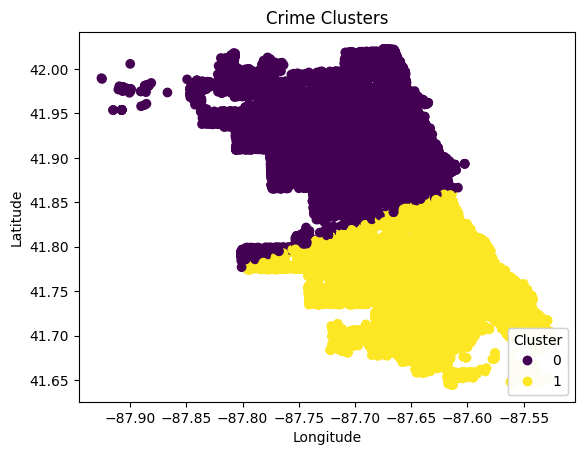

In [ ]:
# Convert the predicted clusters to a Pandas dataframe
pred_df = predictions.toPandas()
# Extract the latitude, longitude, and prediction values from the DataFrame
latitudes = pred_df["features"].apply(lambda x: x[0])
longitudes = pred_df["features"].apply(lambda x: x[1])
predictions = pred_df["prediction"]

# Create the scatterplot
fig, ax = plt.subplots()
scatter = ax.scatter(longitudes, latitudes, c=predictions, cmap='viridis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Crime Clusters')

# Add a colorbar to the scatterplot
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Cluster")
ax.add_artist(legend)

plt.show()

**Recommendation system**

In [ ]:
df = df.sample(fraction=0.1, seed=42)

In [ ]:
# Add a rating column using 'Arrest' column
df = df.withColumn("Rating", (df["Arrest"] == "True").cast("integer"))
# Convert ID and IUCR columns to integers
indexer1 = StringIndexer(inputCol="ID", outputCol="ID_int")
df = indexer1.fit(df).transform(df)
indexer2 = StringIndexer(inputCol="IUCR", outputCol="IUCR_int")
df = indexer2.fit(df).transform(df)
# Select required columns for ALS model
df = df.select("ID_int", "IUCR_int", "Rating")
(training, test) = df.randomSplit([0.8, 0.2], seed=42)
als = ALS(maxIter=10, regParam=0.1, userCol="ID_int", itemCol="IUCR_int", ratingCol="Rating", coldStartStrategy="drop")
model = als.fit(training)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

Root-mean-square error = 0.09792993381748552


In [ ]:
# Generate top 10 recommendations for all users in the testing set
recommendations = model.recommendForAllUsers(10)

In [ ]:
# Show the top 10 recommendations for the first user in the testing set
user_id = test.select("ID_int").first()[0]
user_recommendations = recommendations.filter(recommendations.ID_int == user_id).select("recommendations.IUCR_int")
print("Top 10 recommendations for user ", user_id, ": ", user_recommendations.collect())

Top 10 recommendations for user  2.0 :  [Row(IUCR_int=[99, 98, 97, 96, 95, 94, 93, 92, 91, 90])]


**Preprocessing**

In [ ]:
# getting the count of crime type
counts = df.groupBy('Primary Type').count()
# filtering the crime type classes of count greater than 20000
filtered_df = counts.filter(col('count') > 20000)
# filtered_df.show()
# extracting the "Primary Type" column from the filtered DataFrame
primary_types = filtered_df.select("Primary Type").rdd.flatMap(lambda x: x).collect()
# keeping only the filtered crime type classes of count greater than 20000
filtered_df = df.where(df["Primary Type"].isin(primary_types))
# filtered_df.show()
# converting theses columns from string to integer
columns = ['IUCR', 'Description','FBI Code']
indexers = [StringIndexer(inputCol=column, outputCol=column+"ohe")
            for column in columns]
pipeline = Pipeline(stages=indexers)
indexed_df = pipeline.fit(filtered_df).transform(filtered_df)
features = [ 'IUCRohe', 'Descriptionohe', 'FBI Codeohe']
assembler = VectorAssembler(inputCols=features, outputCol="features")
indexed_df = assembler.transform(indexed_df)
# converting the column values from string to integer
labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="label").fit(indexed_df)
indexed_df = labelIndexer.transform(indexed_df)
# Splitting the dataset to Train and test
train_dataset,test_dataset,  = indexed_df.randomSplit([0.8, 0.2], 3)

**Random Forest**

In [ ]:
# define the random forest model
rf = RandomForestClassifier(labelCol="label", featuresCol="features",
                            numTrees=70, maxBins=400, maxDepth=15, minInstancesPerNode=30)
# train the model
model_rf = rf.fit(train_dataset)
# get predicitions on the test data
predictions_rf = model_rf.transform(test_dataset)

In [ ]:
# Evaluate the performance of the model using the MulticlassClassificationEvaluator
evaluator_rf = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction", metricName="accuracy")
accuracy_rf = evaluator_rf.evaluate(predictions_rf)
print("Random Forest Model accuracy: ", accuracy_rf)

Random Forest Model accuracy:  0.9955929873688973


In [ ]:
# Convert the predicted labels back to their corresponding string labels
labelConverter = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=labelIndexer.labels)
# Transform the predicted labels
predictions_rf = labelConverter.transform(predictions_rf)
# Display the predictions
predictions_rf.select("Primary Type", "predicted_label").show(10)

+-----------------+-----------------+
|     Primary Type|  predicted_label|
+-----------------+-----------------+
|          BATTERY|          BATTERY|
|            THEFT|            THEFT|
|          BATTERY|          BATTERY|
|WEAPONS VIOLATION|WEAPONS VIOLATION|
|            THEFT|            THEFT|
|            THEFT|            THEFT|
|CRIMINAL TRESPASS|CRIMINAL TRESPASS|
|  CRIMINAL DAMAGE|  CRIMINAL DAMAGE|
|            THEFT|            THEFT|
|  CRIMINAL DAMAGE|  CRIMINAL DAMAGE|
+-----------------+-----------------+
only showing top 10 rows



In [ ]:
# Compute the F1 score, precision, and confusion matrix for the model
true_label = predictions_rf.select("label").collect()
pred_label = predictions_rf.select("prediction").collect()
f1_rf = f1_score(true_label, pred_label, average='weighted')
precision_rf = precision_score(true_label, pred_label, average='weighted')
# Print the evaluation metrics for the classifier
print("Evaluation metrics for Random Forest")
print("F1 score =", f1_rf)
print("Precision score =", precision_rf)

Evaluation metrics for Random Forest
F1 score = 0.9954581902150923
Precision score = 0.9957123436009914


In [ ]:
confusion_rf = confusion_matrix(true_label, pred_label)
print("Confusion matrix:\n", confusion_rf)

Confusion matrix:
 [[245165      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0]
 [     0 214669      0      0      0      0      0      0      0      0
       0      0      0      0      0      0]
 [     0      0 139532      0      0      0      0      0      0      0
       0      0      0      0      0      0]
 [     0      0      0 132193      0    604      0      0      0      0
       0      0      0      0      0      0]
 [     0      0      0      0  73029      0      0      0      0      0
       0      0      0      0      0      0]
 [     0      0      0      0      0  72877      0      0      0      0
       0      0      0      8     42      0]
 [     0      0      0      0      0      0  71007      0      0      0
       0      0      0      0      0      0]
 [     0      0      0      0      0      0      0  54072      0      0
       0      0      0      0      0      0]
 [     0      0      0      0      0      0  

In [ ]:
class_labels = predictions_rf.select('Primary Type').distinct().rdd.flatMap(lambda x: x).collect()

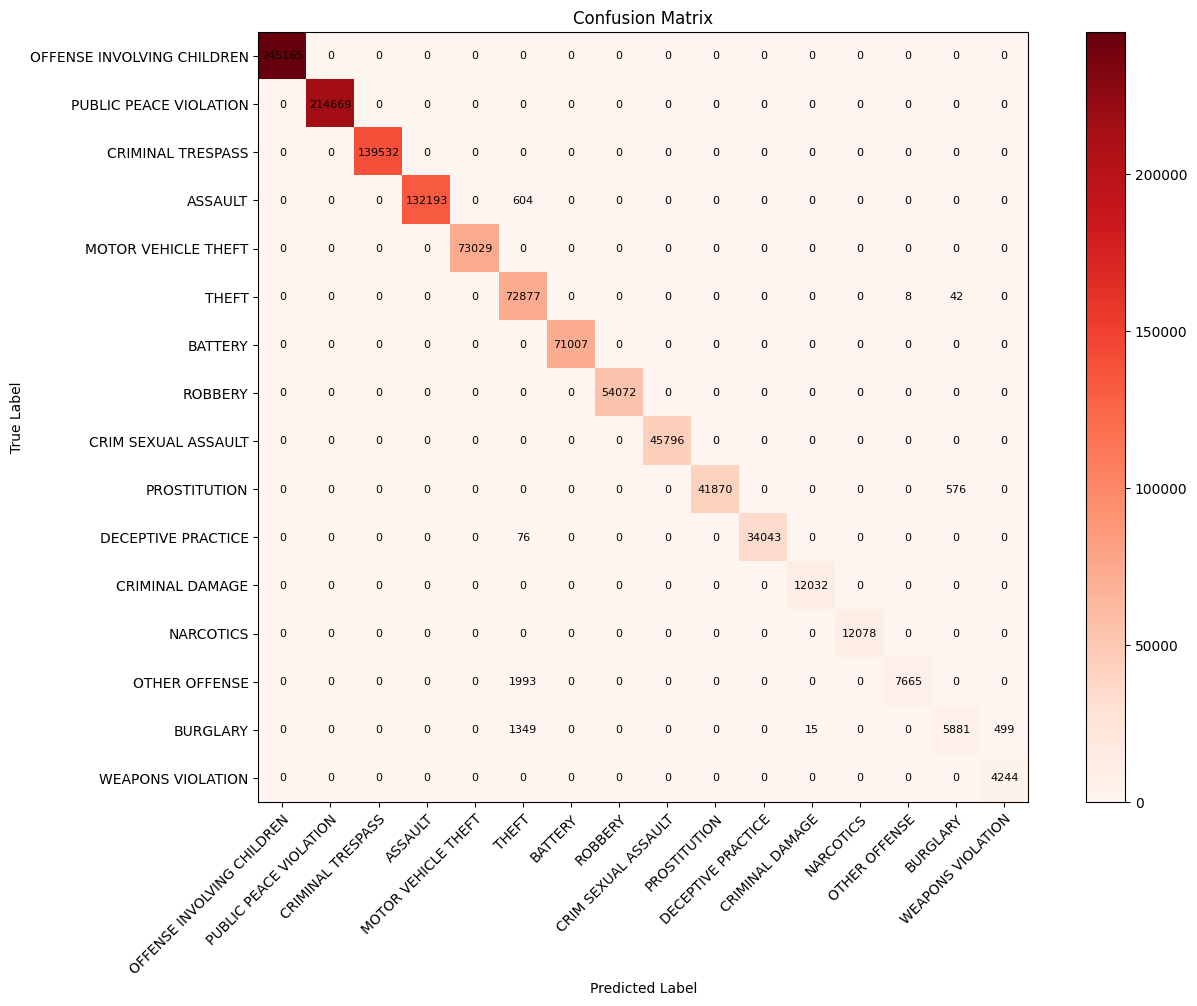

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Define figure and axes
fig, ax = plt.subplots(figsize=(15,10))
im = ax.imshow(confusion_rf, cmap=plt.cm.Reds)
# Set axis labels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)
# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations
for i in range(len(class_labels)):
  for j in range(len(class_labels)):
    text = ax.text(j, i, confusion_rf[i, j], ha="center", va="center", color="black", fontsize=8)
# Set axis labels
ax.set_xlabel('Predicted Label', fontsize=10)
ax.set_ylabel('True Label', fontsize=10)
# Set title and colorbar
ax.set_title("Confusion Matrix", fontsize=12)
plt.colorbar(im)
# Display the plot
plt.show()

**Decision Tree**

In [ ]:
# define the decision model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features",
                            maxBins=400, maxDepth=15, minInstancesPerNode=30)
# train the model
model_dt = dt.fit(train_dataset)
# get predicitions on the test data
predictions_dt = model_dt.transform(test_dataset)

In [ ]:
# Evaluate the performance of the model using the MulticlassClassificationEvaluator
evaluator_dt = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_dt = evaluator_dt.evaluate(predictions_dt)
print("Decision Tree Model accuracy: ", accuracy_dt)

Decision Tree Model accuracy:  0.9910638897307726


In [ ]:
# Convert the predicted labels back to their corresponding string labels
labelConverter = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=labelIndexer.labels)
# Transform the predicted labels
predictions_dt = labelConverter.transform(predictions_dt)
# Display the predictions
predictions_dt.select("Primary Type", "predicted_label").show(10)

+-----------------+-----------------+
|     Primary Type|  predicted_label|
+-----------------+-----------------+
|          BATTERY|          BATTERY|
|            THEFT|            THEFT|
|          BATTERY|          BATTERY|
|WEAPONS VIOLATION|WEAPONS VIOLATION|
|            THEFT|            THEFT|
|            THEFT|            THEFT|
|CRIMINAL TRESPASS|CRIMINAL TRESPASS|
|  CRIMINAL DAMAGE|  CRIMINAL DAMAGE|
|            THEFT|            THEFT|
|  CRIMINAL DAMAGE|  CRIMINAL DAMAGE|
+-----------------+-----------------+
only showing top 10 rows



In [ ]:
# Compute the F1 score, precision, and confusion matrix for the model
true_label = predictions_dt.select("label").collect()
pred_label = predictions_dt.select("prediction").collect()
f1_dt = f1_score(true_label, pred_label, average='weighted')
precision_dt = precision_score(true_label, pred_label, average='weighted')
# Print the evaluation metrics for the classifier
print("Evaluation metrics for Decision Tree")
print("F1 score =", f1_dt)
print("Precision score =", precision_dt)

Evaluation metrics for Decision Tree
F1 score = 0.9878039187591007
Precision score = 0.9849966008600987


In [ ]:
confusion_dt = confusion_matrix(true_label, pred_label)
print("Confusion matrix:\n", confusion_dt)

Confusion matrix:
 [[245165      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0]
 [     0 214669      0      0      0      0      0      0      0      0
       0      0      0      0      0      0]
 [     0      0 139532      0      0      0      0      0      0      0
       0      0      0      0      0      0]
 [     0      0      0 132193      0    604      0      0      0      0
       0      0      0      0      0      0]
 [     0      0      0      0  73029      0      0      0      0      0
       0      0      0      0      0      0]
 [     0      0      0      0      0  72877      0      0      0     42
       0      0      0      8      0      0]
 [     0      0      0      0      0      0  71007      0      0      0
       0      0      0      0      0      0]
 [     0      0      0      0      0      0      0  54072      0      0
       0      0      0      0      0      0]
 [     0      0      0      0      0      0  

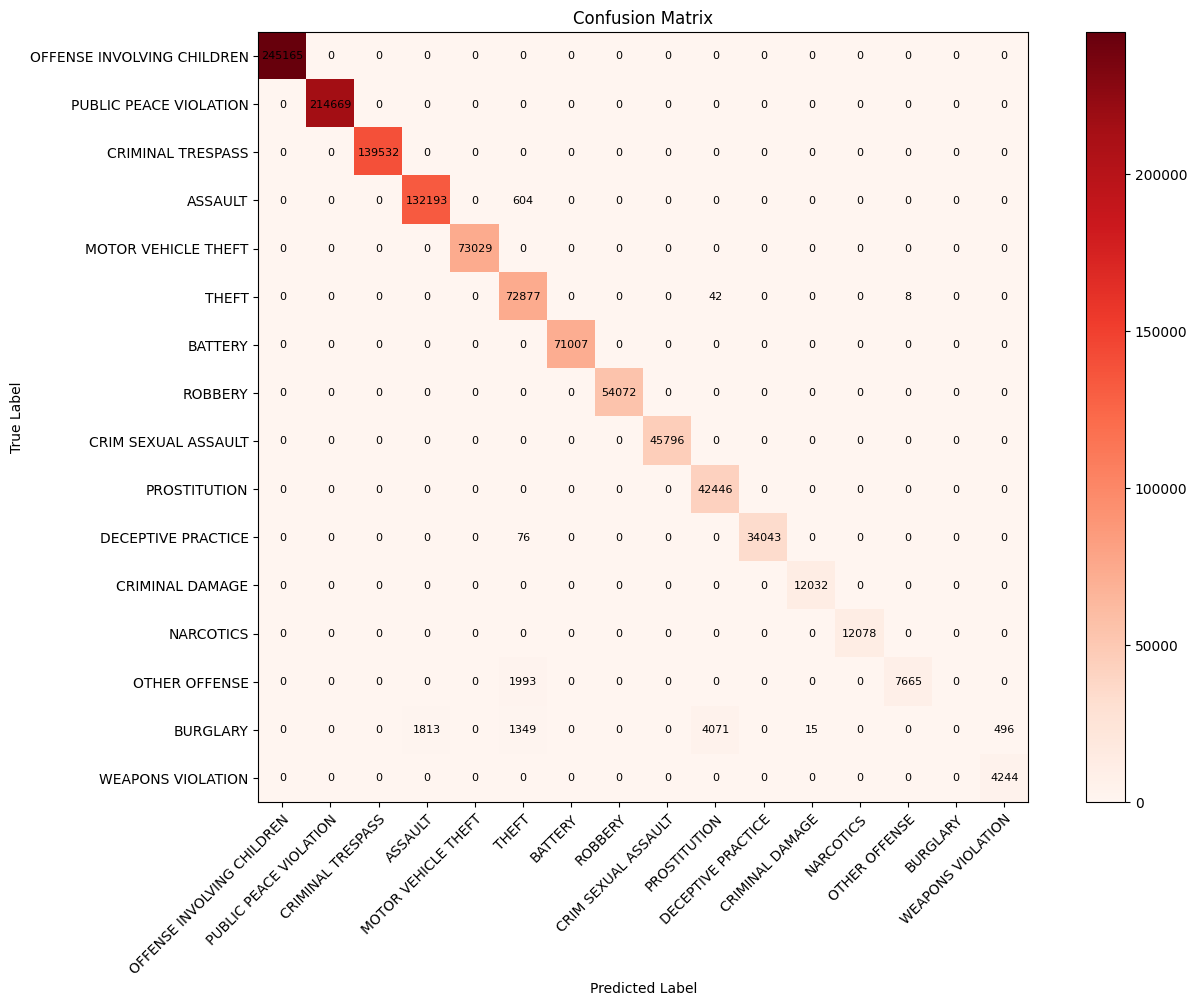

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define figure and axes
fig, ax = plt.subplots(figsize=(15,10))
im = ax.imshow(confusion_dt, cmap=plt.cm.Reds)

# Set axis labels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(len(class_labels)):
  for j in range(len(class_labels)):
    text = ax.text(j, i, confusion_dt[i, j], ha="center", va="center", color="black", fontsize=8)

# Set axis labels
ax.set_xlabel('Predicted Label', fontsize=10)
ax.set_ylabel('True Label', fontsize=10)

# Set title and colorbar
ax.set_title("Confusion Matrix", fontsize=12)
plt.colorbar(im)

# Display the plot
plt.show()
